### Exercise 6: Generative Adversarial Network
In this exercise, you will train a generative adversarial network (GAN) for **generaring images from random noise**

GAN involves two neural network model: **generator** to generate fake images from noisy signal and **discriminator** to discriminate between the real and fake images.

The dataset used in this exercise is the [MNIST](https://yann.lecun.com/exdb/mnist/), which contains of 60000 training images of handwritten digits, from 0 to 9 in grey scale color.


In [1]:
skip_training = False   # You can set it to True if you want to run inference on your trained model.

# Set the parameters
# Do not change the noise size
max_epochs = 20
noise_size = 100
batch_size = 32

<h3>Import all the necessary libraries </h3>

In [3]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms


<h3> Select the device the run the model.</h3>


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


<h3> Download the dataset and create a dataloader to loop through mini batches of data. </h3>

In [5]:
dataset_path = './dataset_ex6' # you can change the path if you want to store the dataset somewhere else.

#### **2 - Dataset**

##### Creating Pytorch Dataset and Dataloader

In [7]:
#MNIST dataset
transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])
dataset = MNIST(root=dataset_path,
                train=True,
                transform=transform,
                download=True,)

train_size = 0.8
test_size = 0.2
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./dataset_ex6/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset_ex6/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]


Extracting ./dataset_ex6/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset_ex6/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting ./dataset_ex6/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset_ex6/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.83MB/s]


Extracting ./dataset_ex6/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset_ex6/MNIST/raw



<h3>Visualizing data</h3>

The following code block visualizes the some of the images from the dataset.

Batch shape: torch.Size([32, 1, 32, 32])


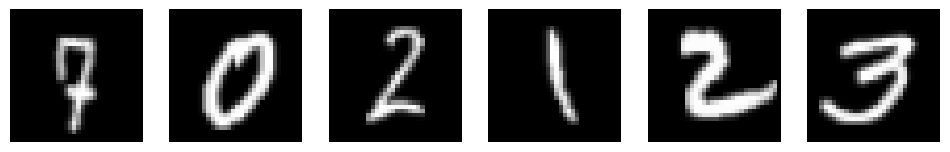

In [8]:
batch, _ = next(iter(train_loader))
displayed_images = batch[:6].squeeze(1)
fig, ax = plt.subplots(1, 6, figsize=(12, 4))

for i in range(6):
    ax[i].imshow(displayed_images[i], cmap='gray')
    ax[i].axis('off')

print(f"Batch shape: {batch.shape}")

<h3>Task 1: Define the Model classes </h3>

<h4>Task 1.1: Define the Discriminator class </h4>


<div style="text-align: center;">
    <img src="disc.png" style="width:800px; height:auto;"/>
</div>

In [ ]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )


    def forward(self,
                x:torch.Tensor) -> torch.Tensor:

        out_conv1 = self.conv1(x)
        out_conv2 = self.conv2(out_conv1)
        out_conv3 = self.conv3(out_conv2)
        out_conv4 = self.conv4(out_conv3)

        out = torch.squeeze(out_conv4, (-1, -2))

        return out

<h4>Task 1.2: Define the Generator class </h4>

<div style="text-align: center;">
    <img src="gen.png" style="width:800px; height:auto;"/>
</div>

In [ ]:
class Generator(nn.Module):
    def __init__(self,
                 noise_size:int,
                 ) -> None:
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = noise_size, out_channels = 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 64, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self,
                x:torch.Tensor) -> torch.Tensor:
        out_conv1 = self.conv1(x)
        out_conv2 = self.conv2(out_conv1)
        out_conv3 = self.conv3(out_conv2)
        out_conv4 = self.conv4(out_conv3)
        return out_conv4

<h3> Task 2: Define the loss function and optimizer.</h3>


In [ ]:
def loss_and_optimizer(generator:Generator,
                       discriminator:Discriminator) -> tuple:
    """Get loss function and optimizers for the generator and discriminator.

    :param generator: Generator model
    :type generator: Generator
    :param discriminator: Discriminator model
    :type discriminator: Discriminator
    :return: Loss function, generator optimizer, discriminator optimizer
    :rtype: tuple
    """
    criterion = nn.BCELoss()

    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

    return criterion, g_optimizer, d_optimizer

In [16]:
generator = Generator(noise_size).to(device)
discriminator = Discriminator().to(device)

criterion, g_optimizer, d_optimizer = loss_and_optimizer(generator, discriminator)

<h3> Task 3: Training loop.</h3>

<h4>Task 3.1: Define discriminator loss</h4>

The discriminator objective is to correctly classify the images into real and fake. <br>


In [ ]:
def forward_discriminator(generator: Generator,
                           discriminator: Discriminator,
                           criterion: nn.Module,
                           real_images: torch.Tensor,
                           noise: torch.Tensor,
                           device: torch.device) -> tuple:
    """Forward pass for the discriminator.

    :param generator: Generator model
    :type generator: Generator
    :param discriminator: Discriminator model
    :type discriminator: Discriminator
    :param criterion: Loss function
    :type criterion: nn.Module
    :param real_images: Real images
    :type real_images: torch.Tensor
    :param noise: Noise vector
    :type noise: torch.Tensor
    :param device: Device (cuda or cpu)
    :type device: torch.device
    :return: Loss, real labels, fake labels (labels are returned for testing purposes)
    :rtype: tuple
    """
    real_labels = torch.ones(real_images.shape[:2]).to(device)

    real_images = real_images.to(device)
    noise = noise.to(device)

    fake_images = generator(noise)
    fake_images.detach()
    fake_labels = torch.zeros(fake_images.shape[:2]).to(device)

    fake_outputs = discriminator(fake_images)
    real_outputs = discriminator(real_images)

    d_loss_fake = criterion(fake_outputs, fake_labels)
    d_loss_real = criterion(real_outputs, real_labels)

    d_loss = d_loss_fake + d_loss_real
    return d_loss, real_labels, fake_labels

<h4>Task 3.2: Define generator loss</h4>

The generator objective is to create fake images that can fool the discriminator <br>

In [ ]:
def forward_generator(generator: Generator,
                        discriminator: Discriminator,
                        criterion: nn.Module,
                        noise: torch.Tensor,
                        device: torch.device) -> tuple:
    """Forward pass for the generator.

    :param generator: Generator model
    :type generator: Generator
    :param discriminator: Discriminator model
    :type discriminator: Discriminator
    :param criterion: Loss function
    :type criterion: nn.Module
    :param noise: Noise vector
    :type noise: torch.Tensor
    :param device: Device (cuda or cpu)
    :type device: torch.device
    :return: Loss, labels (labels are returned for testing purposes)
    :rtype: tuple
    """
    fake_images = generator(noise)
    fake_labels = torch.ones(fake_images.shape[:2]).to(device)
    discriminator_output = discriminator(fake_images)
    g_loss = criterion(discriminator_output, fake_labels)
    return g_loss, fake_labels


<h4>Task 3.3: Define training loop</h4>


In [ ]:
test_img = torch.randn(64, 100, 1, 1).to(device) # fixed noise for visualization during training

def train_gan(generator: Generator,
              discriminator: Discriminator,
              g_optimizer: torch.optim.Optimizer,
              d_optimizer: torch.optim.Optimizer,
              train_dataloader: DataLoader,
              noise_size: torch.Tensor,
              loss: nn.Module,
              device: torch.device,
              max_epochs: int = 20,
              verbose: bool = True) -> tuple:
    """Train the GAN model.

    :param generator: Generator model
    :type generator: Generator
    :param discriminator: Discriminator model
    :type discriminator: Discriminator
    :param g_optimizer: Generator optimizer
    :type g_optimizer: torch.optim.Optimizer
    :param d_optimizer: Discriminator optimizer
    :type d_optimizer: torch.optim.Optimizer
    :param train_dataloader: Training dataloader
    :type train_dataloader: DataLoader
    :param noise_size: Noise vector size
    :type noise_size: torch.Tensor
    :param loss: Loss function
    :type loss: nn.Module
    :param device: Device (cuda or cpu)
    :type device: torch.device
    :param max_epochs: Max number of training epochs, defaults to 20
    :type max_epochs: int, optional
    :param verbose: Printing out training process?, defaults to True
    :type verbose: bool, optional
    :return: Generator losses, Discriminator losses
    :rtype: tuple
    """
    generator_losses = []
    discriminator_losses = []

    generator.train()
    discriminator.train()

    for epoch in range(max_epochs):
        generator_batch_losses = []
        discriminator_batch_losses = []
        for i, (real_images, _) in enumerate(train_dataloader):

            # Move the images to the device
            # Create the noise vector of size (batch_size, noise_size, 1, 1)
            real_images = real_images.to(device)
            noise = torch.randn(batch_size, noise_size, 1, 1).to(device)


            # Train the discriminator
            d_optimizer.zero_grad()
            d_loss, _, _ = forward_discriminator(generator, discriminator, loss, real_images, noise, device)
            d_loss.backward()
            d_optimizer.step()


            # Train the generator
            g_optimizer.zero_grad()
            g_loss, _ = forward_generator(generator, discriminator, loss, noise, device)
            g_loss.backward()
            g_optimizer.step()


            generator_batch_losses.append(g_loss.item())
            discriminator_batch_losses.append(d_loss.item())

        # Visualize the generated images during training on fixed noise
        if verbose:
            print(f"Epoch {epoch}: Generator loss: {np.mean(generator_batch_losses):.2f}. Discriminator loss: {np.mean(discriminator_batch_losses):2f}")
            if epoch % 5 == 0:
                sample_gen_imgs_in_train = generator(test_img).detach().cpu().squeeze()
                nrow, ncols = 1, 5
                fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(6,1.5))
                plt.suptitle(f'Epoch : {epoch}')
                for ncol in range(ncols):
                    axes[ncol].imshow(sample_gen_imgs_in_train[ncol], cmap='gray')
                    axes[ncol].axis('off')
                plt.show()

        generator_losses.append(np.mean(generator_batch_losses))
        discriminator_losses.append(np.mean(discriminator_batch_losses))

    return generator_losses, discriminator_losses

Epoch 0: Generator loss: 8.33. Discriminator loss: 0.010079


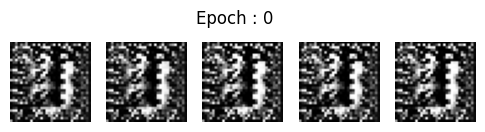

Epoch 1: Generator loss: 5.89. Discriminator loss: 0.100316
Epoch 2: Generator loss: 4.61. Discriminator loss: 0.174850
Epoch 3: Generator loss: 4.80. Discriminator loss: 0.157844
Epoch 4: Generator loss: 5.29. Discriminator loss: 0.106201
Epoch 5: Generator loss: 5.79. Discriminator loss: 0.092256


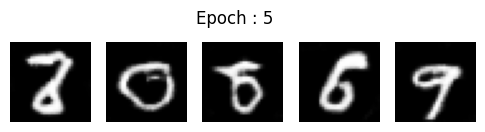

Epoch 6: Generator loss: 6.45. Discriminator loss: 0.065761
Epoch 7: Generator loss: 6.47. Discriminator loss: 0.069869
Epoch 8: Generator loss: 7.19. Discriminator loss: 0.047387
Epoch 9: Generator loss: 7.14. Discriminator loss: 0.045250
Epoch 10: Generator loss: 8.01. Discriminator loss: 0.026829


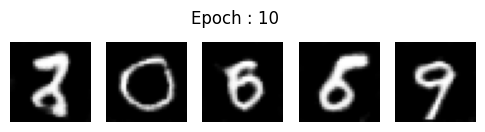

Epoch 11: Generator loss: 7.70. Discriminator loss: 0.045121
Epoch 12: Generator loss: 8.02. Discriminator loss: 0.034355
Epoch 13: Generator loss: 7.60. Discriminator loss: 0.044576
Epoch 14: Generator loss: 8.02. Discriminator loss: 0.031261
Epoch 15: Generator loss: 9.20. Discriminator loss: 0.004734


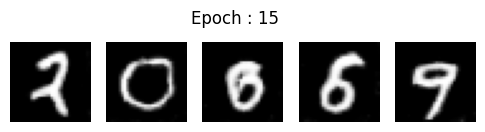

Epoch 16: Generator loss: 8.03. Discriminator loss: 0.051586
Epoch 17: Generator loss: 8.56. Discriminator loss: 0.022881
Epoch 18: Generator loss: 9.17. Discriminator loss: 0.013828
Epoch 19: Generator loss: 8.17. Discriminator loss: 0.037563
Your trained model is saved successfully!


In [28]:
generator = Generator(noise_size).to(device)
discriminator = Discriminator().to(device)

if not skip_training:
    criterion, g_optimizer, d_optimizer = loss_and_optimizer(generator, discriminator)
    gen_losses, disc_losses = train_gan(generator, discriminator, g_optimizer, d_optimizer, train_loader, noise_size, criterion, device, max_epochs=max_epochs, verbose=True)
    torch.save(generator.state_dict(), 'best_generator.pth')
    torch.save(discriminator.state_dict(), 'best_discriminator.pth')
    print("Your trained model is saved successfully!")
else:
    generator.load_state_dict(torch.load('best_generator.pth', map_location=device))
    discriminator.load_state_dict(torch.load('best_discriminator.pth', map_location=device))

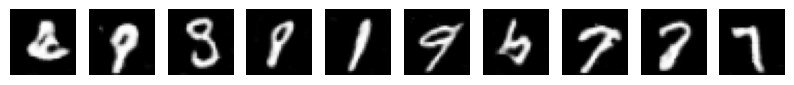

In [29]:
test_img = torch.randn(64, 100, 1, 1).to(device)
sample_gen_imgs_in_train = generator(test_img).detach().cpu().squeeze()
nrow, ncols = 1, 10
fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(10,1.5))
for ncol in range(ncols):
    axes[ncol].imshow(sample_gen_imgs_in_train[ncol], cmap='gray')
    axes[ncol].axis('off')
plt.show()